# How The Threat Landscape Changed in the Pandemic Year 

The purpose of this analysis is to analyze malicious domains submitted to url.abuse[.]ch for the year range of 2019 to 2020. The URL Haus project is an amazing resource used by security practicioners of all kinds to help share and provide insight into malicious urls discovered. The URLhaus project is created and managed by abuse[.]ch, a non profit security reasearcher that manages several additional projects to provide situational awareness and information to aid in internet security against malware.

**The goal of this analysis is to answer the following:**

- What type of malware is more prominant in the year of the pandemic vs the previous year
- Which tld is most seen this year related to malicious threats
- Based on analysis are there any specifc hunts organization can perform to identify traffic going to risky domains.
- Based on analysis are there any detections organizations can put in place to 

**Analysis Breakdown**
- Data Exploration 
- Data Cleaning
- Analysis 
- Reporting and Visualization

In [2]:
import pandas as pd
from csv import reader

#Data Exploration in prep for data cleaning. Converting items in list to quickly asses what the data looks like.


of = open("csv.txt")
rf = reader(of)
data = list(rf)

print(data[:10])


# Data preview of first 10 rows show some header data prior to columns. Will need to skip those rows prior to cleaning.


[['################################################################'], ['# abuse.ch URLhaus Database Dump (CSV)                         #'], ['# Last updated: 2020-12-29 15:44:07 (UTC)                      #'], ['#                                                              #'], ['# Terms Of Use: https://urlhaus.abuse.ch/api/                  #'], ['# For questions please contact urlhaus [at] abuse.ch           #'], ['################################################################'], ['#'], ['# id', 'dateadded', 'url', 'url_status', 'threat', 'tags', 'urlhaus_link', 'reporter'], ['944671', '2020-12-29 15:44:07', 'http://gbimkd.org/wp-includes/mzYzedwYUHNvfwTTy47Ey0o5tKUyazH0oXIs/', 'online', 'malware_download', 'doc,emotet,epoch2', 'https://urlhaus.abuse.ch/url/944671/', 'Cryptolaemus1']]


In [3]:
#Creating a dataframe , but will be skipping first 8 rows of header data.

urls = pd.read_csv("csv.txt",skiprows=8)

columns= urls.columns

print(urls.info(),"\n")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931755 entries, 0 to 931754
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   # id          931755 non-null  int64 
 1   dateadded     931755 non-null  object
 2   url           931755 non-null  object
 3   url_status    931755 non-null  object
 4   threat        931698 non-null  object
 5   tags          931755 non-null  object
 6   urlhaus_link  931755 non-null  object
 7   reporter      931755 non-null  object
dtypes: int64(1), object(7)
memory usage: 56.9+ MB
None 



## Data Exploration and Data Cleaning 

- Dataframe created successfully, identifying over 900,000 entries. 
- Datacleaning steps:
 1. Clean up columns to make them easier to work with
 2. Create a new column for year based on dateadded column
 3. Create a new column for month based on date added column
 4. Identify null values
 5. Create a new column for domain bsed or url
 

In [5]:
#loop through column headers to make naming convention more consistent

columns = urls.columns

print("old columns","\n", columns,"\n")

new_columns = []

for c in columns:
    new = c
    if c == "# id":
        new = "id"
        new_columns.append(new)
    elif c =="dateadded":
        new = "date_added"
        new_columns.append(new)
        
    else:
        new_columns.append(new)
        
urls.columns = new_columns


        
print("new columns", "\n",urls.columns,"\n")


print("data preview: \n",urls.head(2))


old columns 
 Index(['# id', 'dateadded', 'url', 'url_status', 'threat', 'tags',
       'urlhaus_link', 'reporter'],
      dtype='object') 

new columns 
 Index(['id', 'date_added', 'url', 'url_status', 'threat', 'tags',
       'urlhaus_link', 'reporter'],
      dtype='object') 

data preview: 
        id           date_added  \
0  944671  2020-12-29 15:44:07   
1  944670  2020-12-29 15:44:05   

                                                 url url_status  \
0  http://gbimkd.org/wp-includes/mzYzedwYUHNvfwTT...     online   
1                       http://116.124.219.2:55737/i     online   

             threat               tags                          urlhaus_link  \
0  malware_download  doc,emotet,epoch2  https://urlhaus.abuse.ch/url/944671/   
1  malware_download     32-bit,arm,elf  https://urlhaus.abuse.ch/url/944670/   

        reporter  
0  Cryptolaemus1  
1       geenensp  


### Parsing date_added column and creating seperate columns for year and month



In [6]:
import datetime 

#converting date_added field to a date dtype,and creating and adding seperate columns to display month and year.

urls["date_added"] = pd.to_datetime(urls["date_added"])

urls["year"] = urls["date_added"].dt.year
urls["month"] = urls["date_added"].dt.strftime("%b")

In [7]:
print(urls["month"].describe())

print(urls["year"].describe())


count     931755
unique        12
top          Sep
freq      202906
Name: month, dtype: object
count    931755.000000
mean       2019.608268
std           0.663945
min        2018.000000
25%        2019.000000
50%        2020.000000
75%        2020.000000
max        2020.000000
Name: year, dtype: float64


### Parsing url column to extract domain

- Data contained in URL column is a mixture of hardcoded IP's and fqdn's
- Will create a new column named domain_request:
 1. For rows where the URL is an IP address, I will indicate "IP" as domain_request
 2. Fore rows where the URL is a fqdn, I will extract only the tld and append in the column.

- I will use the following data cleaning workflow process
 1. Explore the data in the column
 2. Identify patterns and special cases
 3. Remove non applicable characters
 4. Perform any data type conversions necessary
 5. Rename column or create new column if required.
 
I've previewed the strings below and split them based on the forward slash delimeter as that is is a consisten pattern seen in all url request. i.e. http[s]://[hostname/ip]/[path]




In [8]:
print(urls["url"].str.split("/").head(30))

0     [http:, , gbimkd.org, wp-includes, mzYzedwYUHN...
1                     [http:, , 116.124.219.2:55737, i]
2     [http:, , www.ticketshd.com, wp-content, FUfYN...
3     [http:, , thefiercevagabond.com, cgi-bin, Ebob...
4     [http:, , 175.10.51.6:57578, Mozi.a;chmod+777+...
5     [https:, , www.hintup.com.br, wp-content, FE9Q...
6     [http:, , ondigital.one, wp-admin, up9pp9KLyef...
7     [https:, , hdgarden.vn, wp-includes, aZBWciJOr...
8                     [http:, , 115.56.159.28:57022, i]
9     [https:, , www.lixko.com, wp-includes, LEq9VJd, ]
10    [https:, , surfboarddigital.com, carol-stream-...
11             [https:, , srishtiherbs.com, jms, bq8, ]
12         [https:, , unikaryapools.com, wp, ysFiRq1, ]
13                  [http:, , 207.254.247.210:49250, i]
14                   [http:, , 120.57.103.125:55379, i]
15        [https:, , technicalashish.in, wp-admin, M, ]
16    [http:, , thespaceastronauts.com, wp-content, ...
17        [http:, , sanghuangvip.com, wp-admin, 

Based on the preview of data above, the hostname/ip is located at index 2.

- I will extract the domain/ip and place in a newly created column named host

In [9]:
urls["host"]= urls["url"].str.split("/").str[2]

print(urls["host"].head(10))

0               gbimkd.org
1      116.124.219.2:55737
2        www.ticketshd.com
3    thefiercevagabond.com
4        175.10.51.6:57578
5        www.hintup.com.br
6            ondigital.one
7              hdgarden.vn
8      115.56.159.28:57022
9            www.lixko.com
Name: host, dtype: object


Some additional parsing will need to be completed to isolate the TLD.In the following section I will create an addition new column named tld. To accomplish this, I will need to do the following:
- Perform another split on the coloumn, but this split will be based on the "." dellimeter.
- I will append the last item in the index to the tld column
- Some challenges with the data and observations are
 1. some domains have two tld appended i.e. .org.com
 2. request to IP addresses also include port value.
 
- I will create a test dataframe with a subset of data. For fields that contain":", I will indicate that as an IP, for all others, I will simply take the last domain listed.


In [10]:
testdata= urls[["year","host"]].head(10)

#print(testdata)

testdata["tld"] = testdata["host"].str.split(".").str[-1]

#print(testdata)

filter = testdata["tld"].str.contains(":")



testdata.loc[filter,"tld"] = "ip"

print(testdata)






   year                   host  tld
0  2020             gbimkd.org  org
1  2020    116.124.219.2:55737   ip
2  2020      www.ticketshd.com  com
3  2020  thefiercevagabond.com  com
4  2020      175.10.51.6:57578   ip
5  2020      www.hintup.com.br   br
6  2020          ondigital.one  one
7  2020            hdgarden.vn   vn
8  2020    115.56.159.28:57022   ip
9  2020          www.lixko.com  com


Now that I've testing code on a subset of data, will apply to the full DB and previiew the data below

In [11]:
urls["tld"] = urls["host"].str.split(".").str[-1]

filter = urls["tld"].str.contains(":")

urls.loc[filter,"tld"] = "ip"

print(urls[["year","host","tld"]].head(20))

    year                    host  tld
0   2020              gbimkd.org  org
1   2020     116.124.219.2:55737   ip
2   2020       www.ticketshd.com  com
3   2020   thefiercevagabond.com  com
4   2020       175.10.51.6:57578   ip
5   2020       www.hintup.com.br   br
6   2020           ondigital.one  one
7   2020             hdgarden.vn   vn
8   2020     115.56.159.28:57022   ip
9   2020           www.lixko.com  com
10  2020    surfboarddigital.com  com
11  2020        srishtiherbs.com  com
12  2020       unikaryapools.com  com
13  2020   207.254.247.210:49250   ip
14  2020    120.57.103.125:55379   ip
15  2020      technicalashish.in   in
16  2020  thespaceastronauts.com  com
17  2020        sanghuangvip.com  com
18  2020     117.242.211.7:40745   ip
19  2020  nasabatam.bbtbatam.com  com


## Continuing efforts of data exploration and cleaning

- Evaluate null values
1. There isn't a lot of null values within the dataset. Most null values look to be in the threat column which will not tbe used for analysis. 

- Evaluate tags columns
1. My initial thought would be to create a new table by year just containing the tags and their months
2. I will use the split method to look for a "," than add the tag to the new table.

- Final Comments
 - I've created seperate dataframes for each year with it's tags

 - I parsed through the tags column to create a frequency table for each year
 
 - I will then convert each frequency tables to a dataframe(for their year) to aid in sorting.

In [12]:
#print(urls["tld"].value_counts().head(20))

print(urls.columns)

print(urls.info())


Index(['id', 'date_added', 'url', 'url_status', 'threat', 'tags',
       'urlhaus_link', 'reporter', 'year', 'month', 'host', 'tld'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931755 entries, 0 to 931754
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            931755 non-null  int64         
 1   date_added    931755 non-null  datetime64[ns]
 2   url           931755 non-null  object        
 3   url_status    931755 non-null  object        
 4   threat        931698 non-null  object        
 5   tags          931755 non-null  object        
 6   urlhaus_link  931755 non-null  object        
 7   reporter      931755 non-null  object        
 8   year          931755 non-null  int64         
 9   month         931755 non-null  object        
 10  host          931755 non-null  object        
 11  tld           931755 non-null  object        
dtypes: datetime64[

In [13]:
#2019 Creating a mask to allow me to filter data by year
y19_bool = urls["year"] == 2019
y20_bool = urls["year"] == 2020

#This will filter using boolean mask created to only values of 2019 
t_19 = urls[y19_bool]

# This creates a series of only tag values for 2019
tags_19 = t_19["tags"]

# Empty dict, to house tags. 
tag_freq_19 = {}

#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_19:
    split = t.split(",")
    for s in split:
        if s not in tag_freq_19:
            tag_freq_19[s] = 1
        else:
            tag_freq_19[s] += 1
            
print(tag_freq_19)




{'AgentTesla': 1749, 'exe': 52620, 'None': 8980, 'elf': 60786, 'bashlite': 13963, 'gafgyt': 16350, 'zip': 8869, 'mirai': 32173, 'HawkEye': 516, 'iso': 24, 'Loki': 1081, 'img': 3, 'KPOTStealer': 46, 'AZORult': 1015, 'Trickbot': 1344, 'emotet': 45737, 'heodo': 41401, 'PredatorStealer': 427, 'CAN': 1220, 'Nemty': 4, 'Ransomware': 1876, 'downloader': 149, 'orcus': 8, 'CoinMiner': 175, 'doc': 25379, 'predator': 15, 'SystemBC': 29, 'Raccoon Stealer': 1, 'ServHelper': 24, 'Amadey': 25, 'CobaltStrike': 123, 'powershell': 48, 'geofenced': 3706, 'qbot': 174, 'Quakbot': 178, 'USA': 2170, 'vbs': 6327, 'IcedID': 540, 'BrushaLoader': 1214, 'POR': 2, 'vbs-in-zip': 1, 'Gozi': 5677, 'password': 1957, 'CZE': 28, 'ursnif': 912, 'QuasarRAT': 83, 'rat': 696, 'MetaMorfo': 28, 'CHL': 6, 'redirect': 276, 'opendir': 430, 'RTF': 316, 'NanoCore': 799, 'NetWire': 324, 'Hermes': 1, 'Task': 126, 'RaccoonStealer': 52, 'JPN': 39, 'JP': 1, 'Tinba': 134, 'ArkeiStealer': 206, 'RevengeRAT': 25, 'njRAT': 169, 'TrickbotLoa

In [14]:
#This will filter using boolean mask created to only values of 2020
t_20 = urls[y20_bool]

# This creates a series of only tag values for 2020
tags_20 = t_20["tags"]

# Empty dict, to house tags. 
tag_freq_20 = {}

#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_20:
    split = t.split(",")
    for s in split:
        if s not in tag_freq_20:
            tag_freq_20[s] = 1
        else:
            tag_freq_20[s] += 1
            



In [15]:
#New Dataframe of 2019 Tags
tag19 = pd.Series(tag_freq_19).to_frame().reset_index()

tag19.columns = ["tag","count"]

print(tag19)


#New Dataframe of 2020 Tags

tag20 = pd.Series(tag_freq_20).to_frame().reset_index()

tag20.columns = ["tag","count"]

print(tag20)

                  tag  count
0          AgentTesla   1749
1                 exe  52620
2                None   8980
3                 elf  60786
4            bashlite  13963
..                ...    ...
749             jeefo      1
750             Xpert      1
751   passwordstealer      1
752   passwordstealer      1
753               NDL      1

[754 rows x 2 columns]
           tag  count
0          doc  27521
1       emotet  32796
2       epoch2  15629
3       32-bit  92972
4          arm  13014
..         ...    ...
800    #gafgyt      1
801  lunlayloo      1
802       html      1
803        CZE      1
804   DigiCert      2

[805 rows x 2 columns]


## Breakdown of Tags by month

After successfully parsing the tags by year, I wanted to potentially analyze the tags by month for each year. To accomplish this, I used the template I used above to filter by year.

- I created a dataframe that contained tags and the month they were submitted.
- I also created an empty dataframe with columns of tag and month.
 - I iterated through the table that contained the tags and their corresponding month
 - For each row, I segmented the tag field and month field into their own variables
 - For each tag field, I used the split fuction to parse it based on the "," delimeter.
 - I created a new dictionary entry to append the tag and it's coressponding month

In [16]:
#2019 Creating a mask to allow me to filter data by year
y19_bool = urls["year"] == 2019


#This will filter using boolean mask created to only values of 2019 
t_19 = urls[y19_bool]


# This creates a series of only tag values for 2019
tags_19 = t_19[["tags","month"]]

print(tags_19["month"].value_counts())

tags_table_19 = pd.DataFrame(columns = ['tag', 'month']) 


#print(tags_19)
#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_19.iterrows():
    tag = t[1][0]
    month = t[1][1]
    
    #print(tag)
    #print(month)
    split = tag.split(",")
    for s in split:
            new_row = {"tag":s,"month":month}
            tags_table_19 = tags_table_19.append(new_row,ignore_index=True)
            
            
        
          
            


#print(tags_table_19)
months_19 = tags_table_19["month"].value_counts()

print(months_19)

#print(tags_table_19)



Feb    33842
Mar    19572
Dec    18918
Apr    18716
May    16762
Jan    13694
Oct    13343
Nov    10826
Jul     8180
Sep     7898
Jun     7607
Aug     6918
Name: month, dtype: int64


KeyboardInterrupt: 

In [22]:
#2020 Creating a mask to allow me to filter data by year
y20_bool = urls["year"] == 2020


#This will filter using boolean mask created to only values of 2020
t_20 = urls[y20_bool]

# This creates a series of only tag values for 2020
tags_20 = t_20[["tags","month"]]



tags_table_20 = pd.DataFrame(columns = ['tag', 'month']) 

#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_20.iterrows():
    tag = t[1][0]
    month = t[1][1]
    
    
    split = tag.split(",")
    for s in split:
            new_row = {"tag":s,"month":month}
            tags_table_20 = tags_table_20.append(new_row,ignore_index=True)

months_20 =tags_table_20["month"].value_counts()
print(months_20)

KeyboardInterrupt: 

# Final Analysis on How The Threat Landscape Changed in the Pandemic Year 


If you're still with me by this point, bless your heart. If you've skipped the sections pertaining to the data exploration and cleaning efforts here's a summary:

1. The URL Haus database was obtained on Dec, 29, 2020. The original dataset that I imported had 8 columns originally, with close to 1 million entries. Here's a listing of the original columns:

        ['# id', 'dateadded', 'url', 'url_status', 'threat', 'tags','urlhaus_link', 'reporter'],
 
2. Data Cleaning summary:
     - I cleaned up the column headers to make naming convention more consistent.
     - I converted date_added column data to the date data type,and created seperate columns to display month and year.
     - I created additional columns titled "host" and "tld". The host column would contain the full url, and the tld column would contain the tld (i.e. .com,.org) from the parsed the host field.
     - If the url was an IP address, I simply placed "IP" in "tld" column. 
 
     - Tags column:
         - Each entry often had multiple tags, which essentially caused a list in a list.
         - In order to get full use and valuable information from this column, I initially created a new table with all tags and its coresponding month. For this technique I used the split method to look for a "," for each tag to add it's unique tag to the table.
         - I decided to go one step further and create a table for each year that contained each tags in a seperate line with its corresponding month.
     
3. Final data used in analysis:
    Below is a listing of the final tables I created that was derived from the master data titled "urls". A list of each table's columns and a table descriptions can be seen below:
    
    - urls
      - columns: 'id', 'date_added', 'url', 'url_status', 'threat', 'tags','urlhaus_link', 'reporter', 'year', 'month', 'host', 'tld
      - Description: Full dataset after exploration and cleaning
     
    - tag19
      - columns:
      - Description:
      
    - tags_19
      
    - tag20
      - columns:
      - Description:
      
    - tags_table_19
      - columns:
      - Description:
      
    - tags_table_20
      - columns:
      - Description:
    
3. Analysis Questions:

    - What type of malware is more prominant in the year of the pandemic vs the previous year?
    - Which tld trends are identified in the year of the pandemic vs the previous year?
    - Based on the tags provided, which file types were predominately used to deliver malware?


 
 


### The Year of 2019 in Review

Tags are used with submissions to URL Hause to provide insight into the type of submission. These tags can range from the malicious file type hosted on the domain to the malware family the payload belongs to. Because of the variety, I created a file list to exclude file type to focus primarily on malware families. This list is not an all inclusive list. However, it does count for some of the top file types.

Based on my analysis Emotet , heodo and mirai rounded out the top 3 submitted entries to URLHaus in 2019. Accounting for approximately 48% of all unique tags submitted in 2019.I don't think there's much surprise that Emotet took the top spot in 2019. The well known banking trojan was a huge disrupter in the cyber security space until very recently.Known to primarily spread through email, according to eSentire a Canadian based managed defense and response company, Emotet accounted for 20% of all malware related incidents in that year.

When we review number 2 on the list, Heodo a very near distant cousin to Emotet. It holds very similar characteristics to Emotet, especially with it's primary delivery method through email. 

Number 3 on the list is Mirari, Japanese orgin malware that operates as a botnet.According to cloudflare, Mirari targets heavily on IoT devices such as routers, and home cameras.



              tag  count
15         emotet  45737
16          heodo  41401
7           mirai  32173
261       payload  18353
80         epoch2  18099
5          gafgyt  16350
81         epoch1  15454
4        bashlite  13963
41           Gozi   5677
94       Troldesh   5053
78         hajime   4987
32      geofenced   3706
84       Dreambot   3464
76       Formbook   3092
82         epoch3   2765
35            USA   2170
42       password   1957
20     Ransomware   1876
0      AgentTesla   1749
299        stage2   1568
265           RUS   1351
14       Trickbot   1344
18            CAN   1220
38   BrushaLoader   1214
343         miner   1195 

Percentage of top 3 of total:  0.49


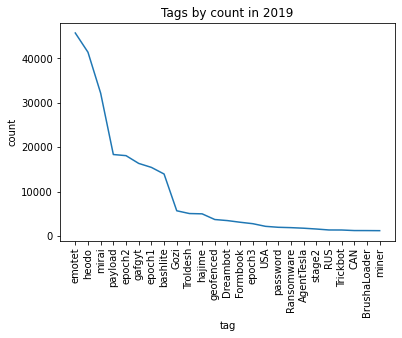

In [54]:
import matplotlib.pyplot as plt

file_list = ["exe","None","doc","zip","xls","vbs","elf","js"]

#Top 25,non file extension tags of 2019 

minus = ~(tag19["tag"].isin(file_list))
top_tags_2019 = tag19[minus].sort_values(by="count",ascending=False).head(25)



plt.plot(top_tags_2019["tag"],top_tags_2019["count"])
plt.xticks(rotation=90)
plt.xlabel("tag")
plt.ylabel("count")
plt.title("Tags by count in 2019")

print(top_tags_2019,"\n")
print("Percentage of top 3 of total: ",(top_tags_2019["count"].head(3).sum()/top_tags_2019["count"].sum()).round(2))

#print("\n","# of Tags by Month","\n")

#print(tags_19["month"].value_counts())






### The Year of 2020 in Review


Mozi https://blog.lumen.com/new-mozi-malware-family-quietly-amasses-iot-bots/



          tag   count
10       Mozi  384226
3      32-bit   92972
7        mips   79660
1      emotet   32796
6       heodo   31264
74     Qakbot   17084
34   Trickbot   16662
2      epoch2   15629
15    opendir   15060
56    Quakbot   14942
13     gafgyt   13217
35      mirai   13123
4         arm   13014
8      epoch1   10578
25   bashlite   10255
52       Gozi    8459
91    ZLoader    7097
22   GuLoader    6383
20     epoch3    6324
21  encrypted    6062


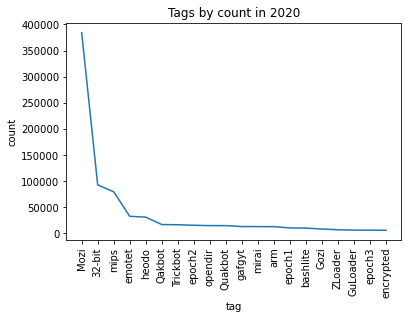

In [55]:
file_mask = ~(tag20["tag"].isin(file_list))

tag_20_final = tag20[file_mask].sort_values(by=["count"],ascending=False).head(20)

plt.plot(tag_20_final["tag"],tag_20_final["count"])

plt.xticks(rotation=90)

plt.xlabel("tag")
plt.ylabel("count")
plt.title("Tags by count in 2020")

print(tag20[file_mask].sort_values(by=["count"],ascending=False).head(20))



Submissions by month

Huge uptick identified in June 2020 vs June 2019

In [56]:
mask = urls["year"] == 2019

sample = urls[["tags","month"]]

counts_19 = sample[mask].value_counts("month")

mask_20 = urls["year"] == 2020

counts_20 = sample[mask_20].value_counts("month")

print(counts_19,"\n","\n",counts_20)


print(months_19)



month
Feb    33842
Mar    19572
Dec    18918
Apr    18716
May    16762
Jan    13694
Oct    13343
Nov    10826
Jul     8180
Sep     7898
Jun     7607
Aug     6918
dtype: int64 
 
 month
Sep    183186
Oct    142419
Nov     97638
Dec     72160
Jun     32890
Aug     25570
Jan     22716
Apr     22079
May     17758
Jul     16443
Feb     15640
Mar     12619
dtype: int64


NameError: name 'months_19' is not defined